# **Lung Cancer Detection**

In [1]:
import pandas as pd

## Loading the Dataset

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Data exploration

In [101]:
df_train.isna().sum()

record_id                0
first_name               0
last_name                0
sex                      0
patient_age              0
residence_state          0
height_cm                0
weight_kg                0
smoking_status           0
cigarettes_per_day       0
cholesterol_mg_dl        0
family_cancer_history    0
has_other_cancer         0
asthma_diagnosis         0
liver_condition          0
blood_pressure_status    0
diagnosis_date           0
cancer_stage             0
treatment_start_date     0
treatment_type           0
treatment_end_date       0
survival_status          0
dtype: int64

In [ ]:
df_test.isna().sum()

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

In [4]:
# Survived to Not Survived Ratio
survived = df_train['survival_status'].value_counts()[1]
not_survived = df_train['survival_status'].value_counts()[0]

survived_ratio = survived/df_train.shape[0]
not_survived_ratio =  not_survived/df_train.shape[0]

print(f"Survived ratio : {survived_ratio} \nNot survived ratio : {not_survived_ratio}")

Survived ratio : 0.2196042196042196 
Not survived ratio : 0.7803957803957804


In [5]:
df_train['survival_status'].value_counts()

survival_status
0    780395
1    219604
Name: count, dtype: int64

## Data Pre-processing
### Data preprocessing Steps
- Filling `cigarattes_per_day` 
- Columns to encode(Binary) : `family_cancer_history`, `has_other_cancer`, `asthma_diagnosis`, `liver_condition`, `blood_pressure_status`
- Columns to encode (OneHot) : `residence_state`, `smoking_status`, `treatment_type`

In [97]:
# Importing the necessory Libraries 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ProcessSmoking(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
        # Current Smokers - no NaNs
        # Never Smoked - no NaNs
        # Former Smokers - no NaNs
        # Passive smokers - contain NaNs
    def transform(self,X):
        X.loc[X['smoking_status'].isin(['Never Smoked', 'Passive Smoker', 'Passive', 'Non Smoker']), 'cigarettes_per_day'] = 0
        return X
    

class ProcessCols(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        # Encode 'family_cancer_history': Yes → 1, No → 0
        X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
        
        # Encode 'has_other_cancer': Yes → 1, No → 0
        X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
        
        # Encode 'asthma_diagnosis': Yes → 1, No → 0
        X['asthma_diagnosis'] = X['asthma_diagnosis'].replace({'Yes': 1, 'No': 0})
        
        # Clean and encode 'blood_pressure_status'
        X['blood_pressure_status'] = X['blood_pressure_status'].replace({
            'High Blood Pressure': 1,
            'Elevated': 1,
            'Normal': 0,
            'Normal BP': 0  # Treating 'Normal' and 'Normal BP' as same
        })
        
        # Clean and encode 'liver_condition'
        X['liver_condition'] = X['liver_condition'].replace({
            'Normal': 0,
            'Normal Liver': 0,
            'Liver OK': 0,
            'No Issue': 0,
            'Has Cirrhosis': 1,
            'Cirrhos': 1  # Assuming typo or shorthand for cirrhosis
        })
        X['sex'] = X['sex'].replace({'Male': 1, 'Female': 0})
        X['smoking_status'] = X['smoking_status'].replace({
            'Current Smoker': 'Current',
            'Former Smoker': 'Former',
            'Passive Smoker': 'Passive',
            'Never Smoked': 'Never',
            'Passive': 'Passive',
            'Non Smoker': 'Never',
            'Former Smk': 'Former'
        })
        X['treatment_type'] = X['treatment_type'].replace({
            'Chemo': 'Chemotherapy',
            'Surg': 'Surgery',
            'Combo': 'Combined'
        })
        X = X.drop('residence_state', axis=1)
        
        return X

class EncodeCatCols(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['smoking_status', 'treatment_type']):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X[self.columns])
        
        # Get column names from OneHotEncoder
        column_names = self.encoder.get_feature_names_out(self.columns)
        
        # Create DataFrame from encoded matrix
        encoded_df = pd.DataFrame(encoded, columns=column_names, index=X.index)
        # Drop original categorical columns and join encoded ones
        X = X.drop(columns=self.columns)
        X = pd.concat([X, encoded_df], axis=1)
        
        return X


class FormatDates(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X['treatment_start_date'] = pd.to_datetime(X['treatment_start_date'], errors='coerce')
        X['treatment_end_date'] = pd.to_datetime(X['treatment_end_date'], errors='coerce')
        X['diagnosis_date'] = pd.to_datetime(X['diagnosis_date'], errors='coerce')
        X['treatment_duration'] = (X['treatment_end_date'] - X['treatment_start_date']).dt.days
        X['diagnosis_to_treatment_delay'] = (X['treatment_start_date'] - X['diagnosis_date']).dt.days
        
        X = X.drop(['treatment_end_date', 'treatment_start_date', 'diagnosis_date'], axis=1)
        return X

class DropUnwantedCols(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X = X.drop(['first_name', 'last_name', 'record_id'], axis=1)
        return X




# Building Data Pre-Processing pipeline
data_pipeline = Pipeline([
    ('process_smoking', ProcessSmoking()),
    ('process_columns', ProcessCols()),
    ('format_dates', FormatDates()),
    ('encode_categoricals', EncodeCatCols(columns=['smoking_status', 'treatment_type'])),
    ('drop_unwanted', DropUnwantedCols())
    # ('scaler', StandardScaler())  
])


C:\Users\User\AppData\Local\Temp\ipykernel_7376\569451648.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_7376\569451648.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_7376\569451648.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

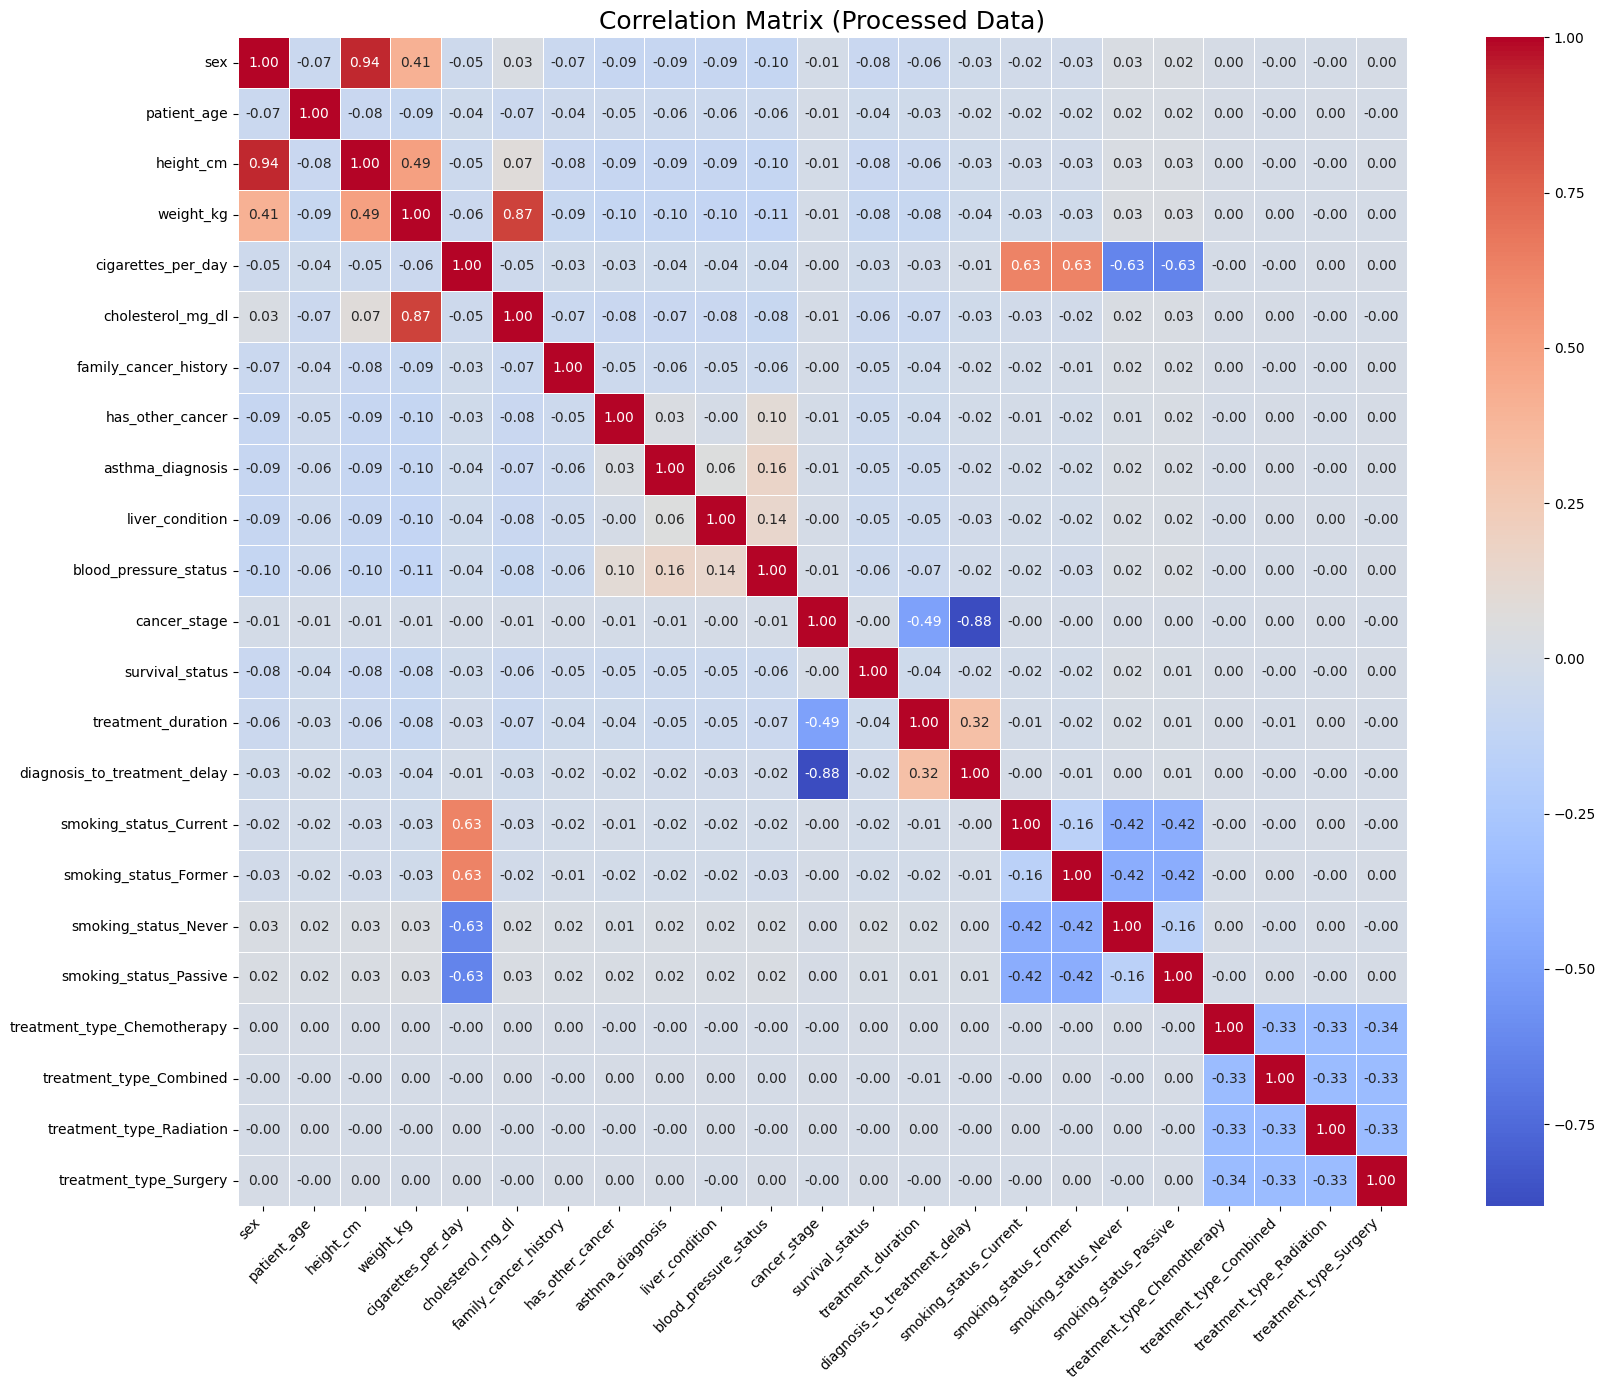

In [98]:
processed_df = data_pipeline.fit_transform(df_train).corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = processed_df.corr()

# Set figure size
plt.figure(figsize=(18, 14))

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, linewidths=0.5)

plt.title("Correlation Matrix (Processed Data)", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Separating Independent Variables (X) and Dependent Variable (y)


In [7]:
X = df_train.drop('survival_status', axis=1)
y = df_train['survival_status']

## Pre-processing data 

In [8]:
X_transformed = data_pipeline.fit_transform(X)

C:\Users\User\AppData\Local\Temp\ipykernel_8896\863333924.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_8896\863333924.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_8896\863333924.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

In [9]:
X_test_transformed = data_pipeline.transform(df_test)

NameError: name 'df_test' is not defined

# Approach - I

## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import numpy as np

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scale features
# -- done --

# 3. Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# 4. Define the neural network with dropout
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# 5. Compile with additional metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])

# 6. Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 7. Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=5,
                    batch_size=64,
                    class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# 8. Evaluate
loss, acc, prec, rec, auc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")

# 9. Predictions
y_pred = (model.predict(X_test) > 0.49).astype("int32")

# 10. Full classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


In [ ]:
df_test_transformed_scaled = data_pipeline.transform(df_test_transformed)

In [ ]:
df_test_transformed_scaled


In [ ]:
y_pred_prob = (model.predict(df_test_transformed_scaled)).flatten()


In [ ]:
y_pred_prob


* 0.498501 - 33.1%
* 0.4984 - 33.9%
* 0.4982 - 35%
* 0.498 - 35.3%
* 0.493 - 35.7%
* 0.49 - 35.8%



In [ ]:
y_pred = (y_pred_prob > 0.49).astype("int32") 

import numpy as np
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
submission = pd.DataFrame({
    'record_id' : df_test['record_id'], 
    'survival_status' : y_pred.flatten()
})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission['survival_status'].value_counts()

## Model Exporting 

In [ ]:
import joblib
model.save('cancer_prediction_model.h5')
joblib.dump(data_pipeline, 'data_pipeline.pkl')



In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Train')
axs[0].plot(history.history['val_accuracy'], label='Val')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Precision
axs[1].plot(history.history['precision'], label='Train')
axs[1].plot(history.history['val_precision'], label='Val')
axs[1].set_title('Precision')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precision')
axs[1].legend()
axs[1].grid(True)

# Recall
axs[2].plot(history.history['recall'], label='Train')
axs[2].plot(history.history['val_recall'], label='Val')
axs[2].set_title('Recall')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Approach - II

## Handling Imbalanced - Under Sampling

In [ ]:
df_train_survived = df_train[df_train['survival_status'] == 1]
df_train_survived['survival_status'].value_counts()

In [ ]:
df_train_not_survived = df_train[df_train['survival_status'] == 0]
df_train_not_survived['survival_status'].value_counts()

In [ ]:
df_train_not_survived_sampled = df_train_not_survived.sample(219604)
df_train_not_survived_sampled.shape

In [ ]:
df_train_sampled = pd.concat([df_train_not_survived_sampled, df_train_survived], axis=0)
df_train_sampled.shape

In [ ]:
X = df_train_sampled.drop('survival_status', axis=1)
y = df_train_sampled['survival_status']

In [79]:
X_train_sampled_transformed = data_pipeline.fit_transform(X)


C:\Users\User\AppData\Local\Temp\ipykernel_7376\3050752241.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_7376\3050752241.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_7376\3050752241.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import numpy as np

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_sampled_transformed, y, test_size=0.2, random_state=42) # , stratify=y

# 2. Scale features
# -- done --

# 3. Compute class weights
# weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(weights))
# print("Class Weights:", class_weights)

# 4. Define the neural network with dropout
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# 5. Compile with additional metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])

# 6. Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=20,
                    batch_size=3000,
                    # class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# 8. Evaluate
loss, acc, prec, rec, auc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")

# 9. Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 10. Full classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


In [ ]:
df_test_transformed = data_pipeline.transform(df_test)
df_test_transformed.shape

In [ ]:
model.save('MetaMorphs_model.h5')

In [ ]:
y_pred_prob = (model.predict(df_test_transformed)).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32") 

import numpy as np
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:

submission = pd.DataFrame({
    'record_id' : df_test['record_id'], 
    'survival_status' : y_pred.flatten()
})
submission.to_csv('submission.csv', index=False)

In [ ]:
min(y_pred_prob), max(y_pred_prob)

# Approach - III

## Pipeline with Advanced Feature Engineering

In [102]:
# Improved preprocessing with better feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class ProcessSmoking(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        # Set cigarettes_per_day to 0 for non-smokers
        X.loc[X['smoking_status'].isin(['Never Smoked', 'Passive Smoker', 'Passive', 'Non Smoker']), 'cigarettes_per_day'] = 0
        
        # Handle missing values in cigarettes_per_day
        X['cigarettes_per_day'] = X['cigarettes_per_day'].fillna(0)
        
        return X

class ProcessCols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Binary encodings
        X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
        X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
        X['asthma_diagnosis'] = X['asthma_diagnosis'].replace({'Yes': 1, 'No': 0})
        X['sex'] = X['sex'].replace({'Male': 1, 'Female': 0})
        
        # Blood pressure with better handling
        X['blood_pressure_status'] = X['blood_pressure_status'].replace({
            'High Blood Pressure': 2,
            'Elevated': 1,
            'Normal': 0,
            'Normal BP': 0
        })
        
        # Liver condition
        X['liver_condition'] = X['liver_condition'].replace({
            'Normal': 0, 'Normal Liver': 0, 'Liver OK': 0, 'No Issue': 0,
            'Has Cirrhosis': 1, 'Cirrhos': 1
        })
        
        # Smoking status standardization
        X['smoking_status'] = X['smoking_status'].replace({
            'Current Smoker': 'Current',
            'Former Smoker': 'Former',
            'Passive Smoker': 'Passive',
            'Never Smoked': 'Never',
            'Passive': 'Passive',
            'Non Smoker': 'Never',
            'Former Smk': 'Former'
        })
        
        # Treatment type
        X['treatment_type'] = X['treatment_type'].replace({
            'Chemo': 'Chemotherapy',
            'Surg': 'Surgery',
            'Combo': 'Combined'
        })
        
        return X

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        
        # BMI calculation
        X['bmi'] = X['weight_kg'] / (X['height_cm'] / 100) ** 2
        
        # Age groups
        X['age_group'] = pd.cut(X['patient_age'], 
                               bins=[0, 40, 55, 70, 100], 
                               labels=['young', 'middle', 'senior', 'elderly'])
        
        # Smoking intensity categories
        X['smoking_intensity'] = pd.cut(X['cigarettes_per_day'], 
                                       bins=[-1, 0, 10, 20, 100], 
                                       labels=['none', 'light', 'moderate', 'heavy'])
        
        # Cancer stage severity
        X['stage_severity'] = X['cancer_stage'].replace({1: 'early', 2: 'early', 3: 'advanced', 4: 'advanced'})
        
        # Risk factors combination
        X['high_risk_combo'] = (
            (X['cancer_stage'] >= 3) & 
            (X['cigarettes_per_day'] > 10) & 
            (X['family_cancer_history'] == 1)
        ).astype(int)
        
        return X

class FormatDates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Convert dates
        X['treatment_start_date'] = pd.to_datetime(X['treatment_start_date'], errors='coerce')
        X['treatment_end_date'] = pd.to_datetime(X['treatment_end_date'], errors='coerce')
        X['diagnosis_date'] = pd.to_datetime(X['diagnosis_date'], errors='coerce')
        
        # Calculate durations
        X['treatment_duration'] = (X['treatment_end_date'] - X['treatment_start_date']).dt.days
        X['diagnosis_to_treatment_delay'] = (X['treatment_start_date'] - X['diagnosis_date']).dt.days
        
        # Handle negative or extreme values
        X['treatment_duration'] = X['treatment_duration'].clip(0, 365*2)  # Max 2 years
        X['diagnosis_to_treatment_delay'] = X['diagnosis_to_treatment_delay'].clip(0, 365)  # Max 1 year
        
        # Fill missing values
        X['treatment_duration'] = X['treatment_duration'].fillna(X['treatment_duration'].median())
        X['diagnosis_to_treatment_delay'] = X['diagnosis_to_treatment_delay'].fillna(X['diagnosis_to_treatment_delay'].median())
        
        # Extract year and month for potential seasonality
        X['diagnosis_year'] = X['diagnosis_date'].dt.year
        X['diagnosis_month'] = X['diagnosis_date'].dt.month
        
        # Drop original date columns
        X = X.drop(['treatment_end_date', 'treatment_start_date', 'diagnosis_date'], axis=1)
        
        return X

class EncodeCatCols(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['smoking_status', 'treatment_type', 'age_group', 'smoking_intensity', 'stage_severity']):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        X = X.copy()
        encoded = self.encoder.transform(X[self.columns])
        column_names = self.encoder.get_feature_names_out(self.columns)
        encoded_df = pd.DataFrame(encoded, columns=column_names, index=X.index)
        X = X.drop(columns=self.columns)
        X = pd.concat([X, encoded_df], axis=1)
        return X

class DropUnwantedCols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        drop_cols = ['pat', 'first_name', 'last_name', 'record_id', 'residence_state','patient_age', 'height_cm','cholesterol_mg_dl', 'diagnosis_to_treatment_delay', 'height_cm','diagnosis_month', 'diagnosis_year']
        existing_cols = [col for col in drop_cols if col in X.columns]
        X = X.drop(existing_cols, axis=1)
        return X

# Improved pipeline
data_pipeline = Pipeline([
    ('process_smoking', ProcessSmoking()),
    ('process_columns', ProcessCols()),
    ('feature_engineering', FeatureEngineering()),
    ('format_dates', FormatDates()),
    ('encode_categoricals', EncodeCatCols()),
    ('drop_unwanted', DropUnwantedCols()),
    ('scaler', StandardScaler())  
])

"patient_age", "height_cm","diagnosis_month", "diagnosis_year", 

In [12]:
df_train_survived = df_train[df_train['survival_status'] == 1]
df_train_survived['survival_status'].value_counts()

survival_status
1    219604
Name: count, dtype: int64

In [13]:
df_train_not_survived = df_train[df_train['survival_status'] == 0]
df_train_not_survived['survival_status'].value_counts()

survival_status
0    780395
Name: count, dtype: int64

### Under Sampling

In [14]:
df_train_not_survived_sampled = df_train_not_survived.sample(400000)
df_train_not_survived_sampled.shape

(400000, 22)

### Over Sampling

In [15]:
df_train_survived_sampled = df_train_survived.sample(400000,replace=True)
df_train_survived_sampled.shape

(400000, 22)

In [16]:
df_train_sampled = pd.concat([df_train_not_survived_sampled, df_train_survived_sampled], axis=0)
df_train_sampled.shape

(800000, 22)

In [87]:
X = df_train_sampled.drop('survival_status', axis=1)
y = df_train_sampled['survival_status']

X_transformed = data_pipeline.fit_transform(X)

NameError: name 'df_train_sampled' is not defined

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import numpy as np

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42) # , stratify=y

# 2. Scale features
# -- done --

# 3. Compute class weights
# weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(weights))
# print("Class Weights:", class_weights)

# 4. Define the neural network with dropout
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# 5. Compile with additional metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])

# 6. Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=20,
                    batch_size=3000,
                    # class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# 8. Evaluate
loss, acc, prec, rec, auc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")

# 9. Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 10. Full classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5017 - auc: 0.5027 - loss: 0.6976 - precision: 0.5019 - recall: 0.5032 - val_accuracy: 0.5006 - val_auc: 0.4986 - val_loss: 0.6933 - val_precision: 0.5005 - val_recall: 0.4813
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5022 - auc: 0.5029 - loss: 0.6935 - precision: 0.5025 - recall: 0.5167 - val_accuracy: 0.5025 - val_auc: 0.5010 - val_loss: 0.6932 - val_precision: 0.5027 - val_recall: 0.4458
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5024 - auc: 0.5044 - loss: 0.6933 - precision: 0.5023 - recall: 0.4872 - val_accuracy: 0.4998 - val_auc: 0.4994 - val_loss: 0.6932 - val_precision: 0.4995 - val_recall: 0.3690
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5030 - auc: 0.5045 - loss: 0.6932 - precision: 0.5024 - recall: 0.4460 - val_accuracy: 0.5024 - val_auc: 0.5028 - val_loss: 0.6932 - val_precision: 0.5013 - val_recall: 0.8184
Epoch 5/20
192/192 ━━━━━━━━━

In [20]:
! pip install imbalanced-learn



   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-lea

## Approach - IV (SMOTE)

In [104]:
X = df_train.drop('survival_status', axis=1)
y = df_train['survival_status']


In [105]:
X_transformed = data_pipeline.fit_transform(X)


In [106]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="minority")
X_sm, y_sm = smote.fit_resample(X_transformed, y)

In [107]:
y_sm.value_counts()

survival_status
0    780395
1    780395
Name: count, dtype: int64

In [148]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import numpy as np

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42) # , stratify=y

# 2. Scale features
# -- done --

# 3. Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
# print("Class Weights:", class_weights)

# 4. Define the neural network with dropout
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# 5. Compile with additional metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])

# 6. Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 7. Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=100,
                    batch_size=(4096*8),
                    # class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# 8. Evaluate
loss, acc, prec, rec, auc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")

# 9. Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 10. Full classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.4994 - auc: 0.4993 - loss: 0.7231 - precision: 0.4994 - recall: 0.6115 - val_accuracy: 0.5006 - val_auc: 0.5017 - val_loss: 0.6939 - val_precision: 0.5002 - val_recall: 0.6426
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5022 - auc: 0.5029 - loss: 0.6940 - precision: 0.5027 - recall: 0.5017 - val_accuracy: 0.5034 - val_auc: 0.5048 - val_loss: 0.6933 - val_precision: 0.5031 - val_recall: 0.4818
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5031 - auc: 0.5044 - loss: 0.6936 - precision: 0.5036 - recall: 0.5090 - val_accuracy: 0.5066 - val_auc: 0.5092 - val_loss: 0.6930 - val_precision: 0.5067 - val_recall: 0.4723
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5041 - auc: 0.5064 - loss: 0.6933 - precision: 0.5043 - recall: 0.4783 - val_accuracy: 0.5095 - val_auc: 0.5124 - val_loss: 0.6929 - val_precision: 0.5098 - val_recall: 0.4722
Epoch 5/100
35/35 ━━━━━━━━━

In [149]:
df_test_transformed = data_pipeline.transform(df_test)

C:\Users\User\AppData\Local\Temp\ipykernel_7376\3014405769.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_7376\3014405769.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_7376\3014405769.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in 

In [150]:
df_test_transformed

array([[-0.99944116, -1.23482472,  1.89535662, ..., -0.99857202,
        -0.99848415,  0.99848415],
       [ 1.00055916,  0.58751541, -0.79140667, ...,  1.00143002,
        -0.99848415,  0.99848415],
       [-0.99944116,  0.35487624, -0.79140667, ...,  1.00143002,
        -0.99848415,  0.99848415],
       ...,
       [ 1.00055916,  1.90580401,  1.57926682, ..., -0.99857202,
        -0.99848415,  0.99848415],
       [-0.99944116, -0.96341236, -0.79140667, ...,  1.00143002,
         1.00151815, -1.00151815],
       [ 1.00055916,  1.98335039, -0.79140667, ...,  1.00143002,
        -0.99848415,  0.99848415]])

In [151]:
y_pred_prob = (model.predict(df_test_transformed)).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32") 

import numpy as np
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
{0: 218007, 1: 31993}


In the test data : 
    1 -> 36%
    0 -> 64%

In [153]:
submission = pd.DataFrame({
    'record_id' : df_test['record_id'], 
    'survival_status' : y_pred.flatten()
})
submission.to_csv('submission.csv', index=False)

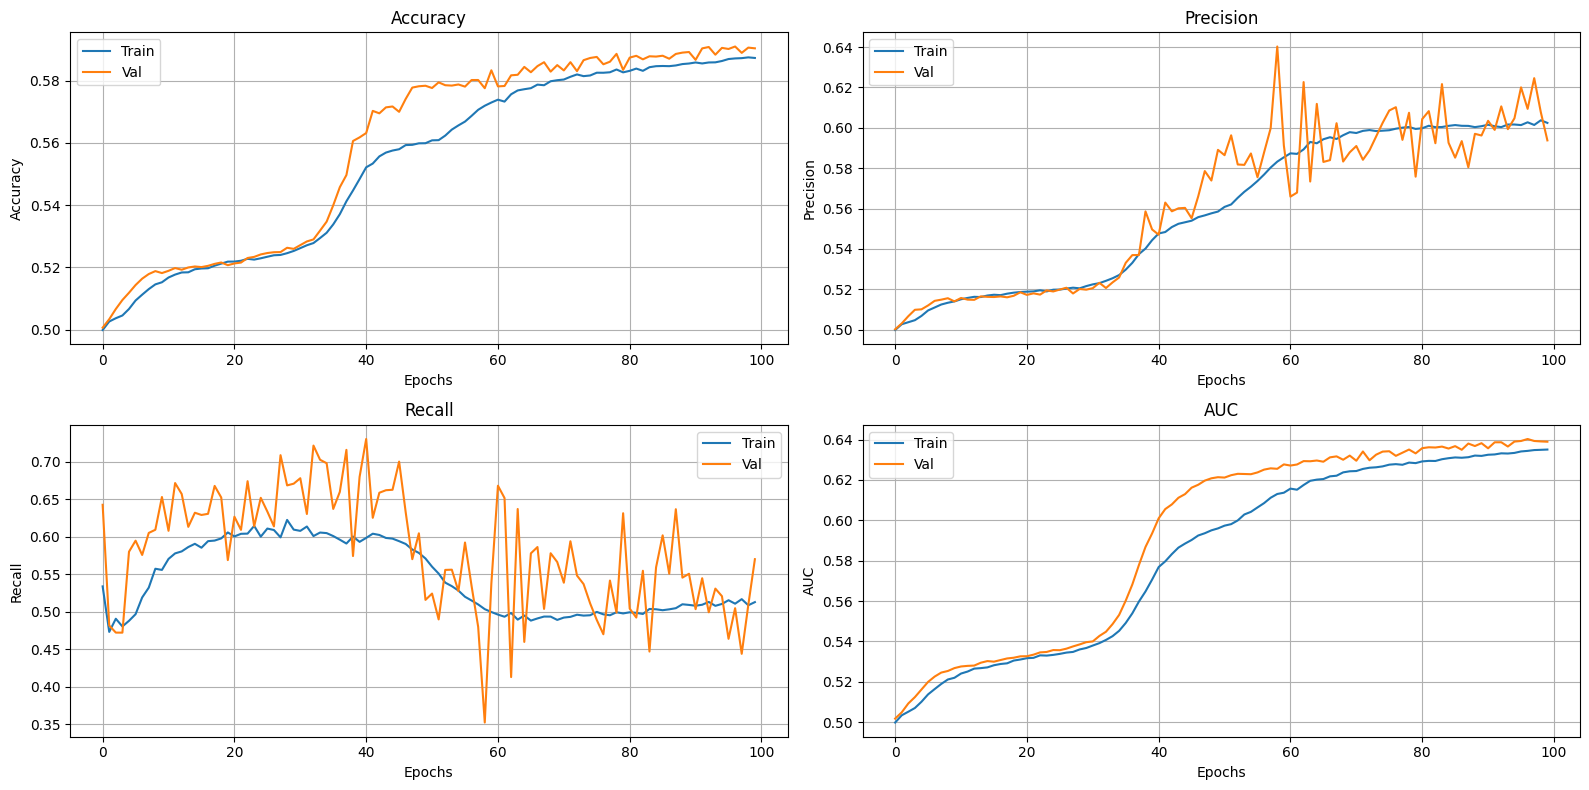

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Val')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Val')
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()